## **Compute and fit galaxy profiles in IllustrisTNG**

This notebook contains code for computing a galaxy profile from the IllustrisTNG simulations and then fitting it with the Diemer-Kravstov 2014 fitting formula. In addition to using the $\texttt{splashback_tools}$ code in this repository, it also uses the $\texttt{illustris_python}$ package which is available at: https://github.com/illustristng/illustris_python

In [1]:
from splashback_tools.profiles import fit_profs, mc_chain
import numpy as np
import scipy
import os
import matplotlib.pyplot as plt

%config InlineBackend.figure_format='retina'   # Makes inline plots look better (at least on mac)

## Load Profiles

In [2]:
with np.load('real_data/data.npz') as file:
    sigma = file['Sigma']
    cov = file['cov']

In [3]:
def rspace(count):
    return np.logspace(np.log10(0.1),np.log10(60.), count)
rbin = rspace(25)
rguess = rspace(1000)
#rmid = ((2./3.)*(rbin[1:]**3-rbin[:-1]**3)/(rbin[1:]**2-rbin[:-1]**2))
rguess = np.logspace(np.log10(0.1),np.log10(60.),1000)

## Plot Profiles

<ErrorbarContainer object of 3 artists>

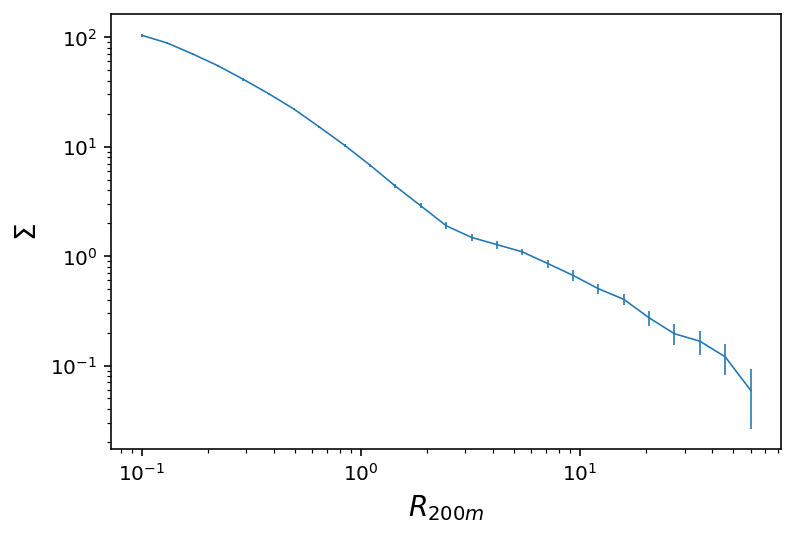

In [4]:
def plot_profile(ax, prof, **kwargs):
    ax.errorbar(prof['r'], prof['dens'], yerr = np.sqrt(np.diag(prof['cov'])), linewidth = 0.8, **kwargs)

ax = plt.gca()
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_ylabel(r"$\Sigma$", fontsize=14)
ax.set_xlabel(r"$R_{200m}$", fontsize=14)

ax.errorbar(rbin, sigma, yerr = np.sqrt(np.diag(cov)), linewidth = 0.8)


##### **Fit the galaxy density profiles**

Now we can fit the profiles and estimate the splashback radii. All we need to do is run the fit_profs.fit_DK_14 function with the profiles as input. The input for this function is a tuple of the form (r, rho, cov) so we define a function get_data_vec to format our measured profiles so that they are accepted by the fit_profs_fit_DK_14 function. The fitting function can save the output if a save directory is specified. In this case we do not save the output and instead analyze it in this notebook. 

You will also need to specify a `basepath` for Multinest to run the sampler. I have specified this as `/u/samgolds/lib/splashback_tools/splashback_tools/multinest_samples`, but it will need to be changed to a directory on the computer you are working on.

The output of the fit is an $11 \times N$ dimensional array where $N$ is the number of multinest samples (multinest determines this based on convergence criterion). The first 9 columns are the DK14 model parameters. The 10th column is the weights and the 11th is the negative log likelihood. So to find the best fit we find the sample with minimum negative log likelihood. In practice we should run a dedicated minimizer afterwards, but this is good enough for now.

In [5]:
from splashback_tools.profiles.mc_chain import McChain

basepath = '/home/liunicholas6/projects/miscentered-clusters/splashback_tools/multinest_samples'
data_vec = (rbin, sigma, cov)
fit = fit_profs.fit_profile(data_vec, basepath, is_2d = True)
theta = fit[0:9].T
loglikes = fit[-1]
weights = fit[-2]
chain = McChain(weights, loglikes, theta = theta)

Fitting profiles with multinest
 *****************************************************
 MultiNest v3.10
 Copyright Farhan Feroz & Mike Hobson
 Release Jul 2015

 no. of live points =  500
 dimensionality =    9
 *****************************************************
  analysing data from /home/liunicholas6/projects/miscentered-clusters/splashback_tools/multinest_samples.txt
 ln(ev)=  -115.10257772895903      +/-  0.22652327400432720     
 Total Likelihood Evaluations:        67947
 Sampling finished. Exiting MultiNest


In [6]:
#Save chains
import pickle as pkl
with open(f"chain_real.bin", "wb") as file:
    pkl.dump(chain, file)

In [7]:
#Load chains
import pickle as pkl
with open(f"chain_real.bin", "rb") as file:
    chain = pkl.load(file)

# Plot Galaxy Profiles with Best Fit

In [8]:
chain.samples

{'theta': array([[-1.33507855, -0.14736334,  4.19894287, ..., -1.1587163 ,
          2.16136775, -2.53500942],
        [-0.61771175,  0.47645257,  5.61151009, ..., -1.37783351,
          1.88958256, -4.01778127],
        [-0.96177063,  0.01416173,  5.70220255, ..., -1.46139745,
          2.57517505, -3.98179411],
        ...,
        [-0.64493607,  0.11911749,  3.25088229, ..., -0.11799638,
          2.49276045, -1.90850868],
        [-0.63373628,  0.11752772,  3.25889261, ..., -0.11669011,
          1.90665359, -1.90995724],
        [-0.63076864,  0.13414343,  3.25873585, ..., -0.12619673,
          2.60728515, -1.9055194 ]])}

In [9]:
# Get maximum likelihood
mle = chain.samples['theta'][np.argmin(chain.loglikes)]

##### **Plot the galaxy density profiles with the bestfit**

Check if the fits worked

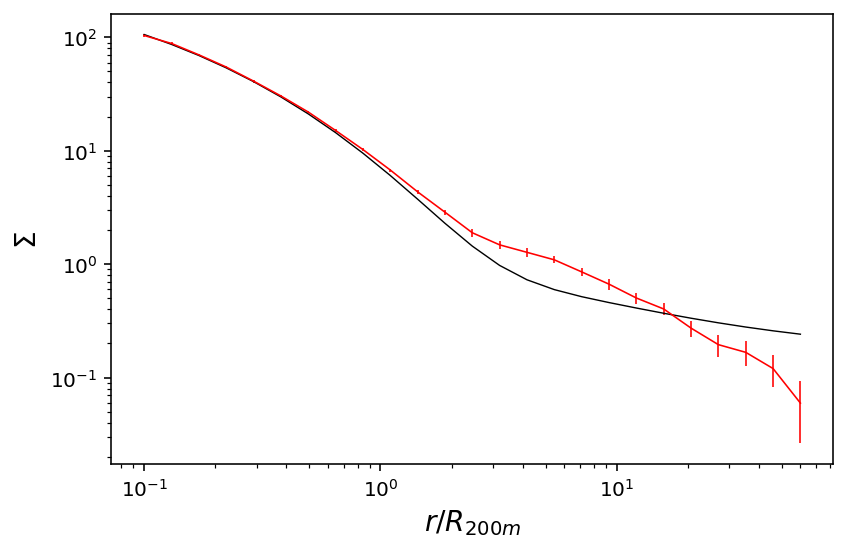

In [10]:
ax = plt.gca()

#Plot profile
ax.errorbar(rbin, sigma, yerr = np.sqrt(np.diag(cov)), color = 'r', linewidth = 0.8)

#Set axes
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_ylabel(r"$\Sigma$", fontsize=14)
ax.set_xlabel(r"$r/R_{200m}$", fontsize=14)

#Plot theory curves
ax.plot(rbin, fit_profs.sigma(fit_profs.rho_d22)(mle, rbin), color='k', linewidth=0.7)

#Label

plt.tight_layout()

##### **Determine splashback posterior**

We can then determine the splashback radius by looping through the samples in the chain and determining the location of minimum log derivative for each sample. I will only do this for one of the cluster mass bins for now

In [11]:
from tqdm import tqdm
import os
import joblib

if 'OMP_NUM_THREADS' in os.environ.keys():
    n_threads = int(os.environ['OMP_NUM_THREADS'])
else:
    n_threads = os.cpu_count()

samps = chain.samples['theta']
n = chain.n_samp

def get_log_derivs(ind):
    samp = samps[ind]
    return fit_profs.log_deriv_d22(samp, rbin)

def get_rsps(ind):
    samp = samps[ind]
    log_derivs = fit_profs.log_deriv_d22(samp, rguess)
    return rguess[np.argmin(log_derivs)]


log_deriv = np.array(joblib.Parallel(n_threads)(joblib.delayed(get_log_derivs)(i)
                                       for i in tqdm(range(n))))

rsp = np.array(joblib.Parallel(n_threads)(joblib.delayed(get_rsps)(i)
                                       for i in tqdm(range(n))))

chain.add_samps(log_deriv = log_deriv, rsp = rsp)

100%|██████████████████████████████████████████████████████████████████████████| 13718/13718 [00:01<00:00, 11653.22it/s]


##### **Plot splashback posterior**

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


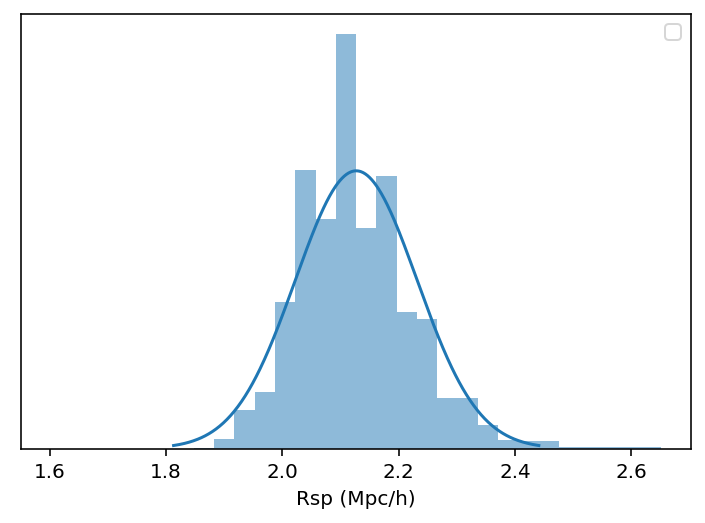

In [12]:
ax = plt.gca()
ax.set_xlabel("Rsp (Mpc/h)")
chain.plot_1d_posterior('rsp', ax)


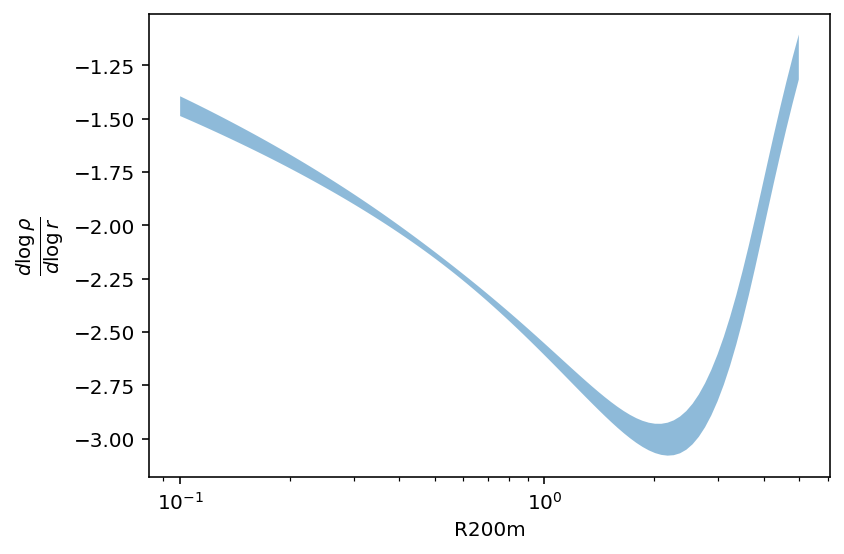

In [18]:
from scipy.interpolate import CubicSpline

def plot_log_deriv_processed(ax, chain, r_log_deriv, r_thr, **kwargs):
    """
    Plot smoothed density curve of splashback posterior
    """
    
    # Get 1 sigma interval on the derived chains
    
    mean, std = chain.get_samp_stats('log_deriv')
    lower_pts, upper_pts = mean - std, mean + std
    
    lower_spline = CubicSpline(r_log_deriv, lower_pts)
    upper_spline = CubicSpline(r_log_deriv, upper_pts)
    
    ax.fill_between(r_thr, lower_spline(r_thr), upper_spline(r_thr), alpha=0.5, **kwargs)
    ax.set_xscale('log')

r_thr = np.logspace(-1, np.log10(5), 100)

ax = plt.gca()
ax.set_xlabel("R200m")
ax.set_ylabel(r"$\frac{d\log\rho}{d\log r}$", fontsize = 14)
plot_log_deriv_processed(ax, chain, rbin, r_thr)
    
plt.tight_layout()

##### **Plot constraints on logarithmic derivative**

# Splashback Mass

## Plot Splashback Mass Posteriors

In [19]:
from itertools import tee
def pairwise(iterable):
    a, b = tee(iterable)
    next(b, None)
    return zip(a, b)

In [20]:
with np.load('splashback_mass_chart.npz') as file:
    rsp_chart = file['rsp']
    msp_chart = file['msp']
    rsp_chart_err = file['rsp_err']
    msp_chart_err = file['msp_err']

<ErrorbarContainer object of 3 artists>

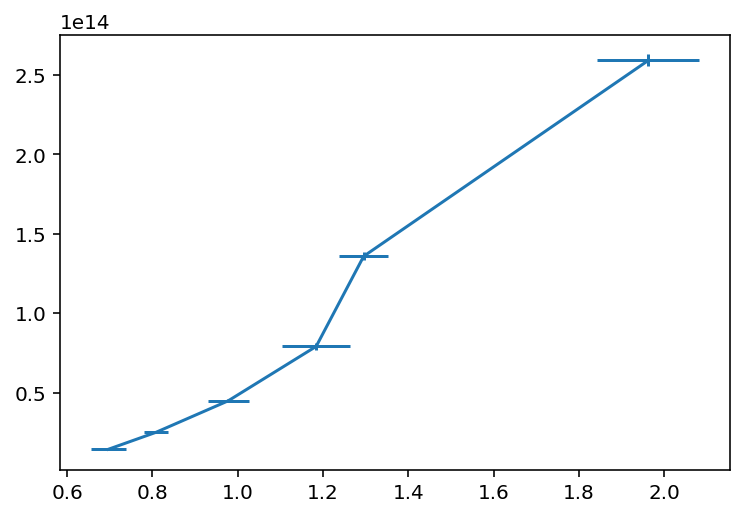

In [21]:
ax = plt.gca()
ax.errorbar(x = rsp_chart, y = msp_chart, xerr = rsp_chart_err, yerr = msp_chart_err)

In [22]:
def build_get_msp(rsp, msp):
    def get_msp(r):
        for (rl, ml), (rr, mr) in pairwise(zip(rsp, msp)):
            if rl < r < ml:
                slope = (mr - ml)/(rr - rl)
                return ml + slope * (r - rl)
        return None
    return get_msp

get_msp = build_get_msp(rsp_chart, msp_chart)

In [23]:
get_msp(np.mean(rsp)) / 10**14

2.1527378467693254e+00